# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

## Загрузка и подготовка данных

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as st

from math import sqrt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
from numpy.random import RandomState

STATE = RandomState(12345)

import warnings
warnings.filterwarnings('ignore')



In [3]:
df1 = pd.read_csv('/datasets/geo_data_0.csv')
df2 = pd.read_csv('/datasets/geo_data_1.csv')
df3 = pd.read_csv('/datasets/geo_data_2.csv')

all_df=(df1, df2, df3)

In [4]:
df1.head(1)

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.22117,105.280062


In [5]:
def df_analyse(data):
    data.info()
    display(data.head(10))
    print(f'размер:    {data.shape}')
    print('пропусков:         ', data.isna().sum().sum())
    print('дубликатов:   ', data.duplicated().sum())
    display(data.describe())
    print('\nРаспределение признаков:')
    plt.figure(figsize=(20, 10))
    data[['f0','f1','f2']].hist()
    
    plt.show()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
5,wX4Hy,0.969570,0.489775,-0.735383,64.741541
6,tL6pL,0.645075,0.530656,1.780266,49.055285
7,BYPU6,-0.400648,0.808337,-5.624670,72.943292
8,j9Oui,0.643105,-0.551583,2.372141,113.356160
9,OLuZU,2.173381,0.563698,9.441852,127.910945


размер:    (100000, 5)
пропусков:          0
дубликатов:    0


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347



Распределение признаков:


<Figure size 1440x720 with 0 Axes>

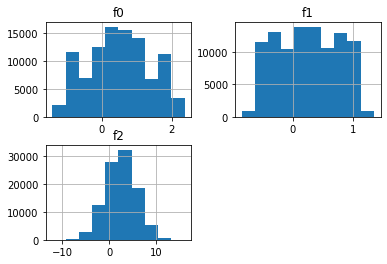

In [6]:
df_analyse(df1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
5,HHckp,-3.327590,-2.205276,3.003647,84.038886
6,h5Ujo,-11.142655,-10.133399,4.002382,110.992147
7,muH9x,4.234715,-0.001354,2.004588,53.906522
8,YiRkx,13.355129,-0.332068,4.998647,134.766305
9,jG6Gi,1.069227,-11.025667,4.997844,137.945408


размер:    (100000, 5)
пропусков:          0
дубликатов:    0


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408



Распределение признаков:


<Figure size 1440x720 with 0 Axes>

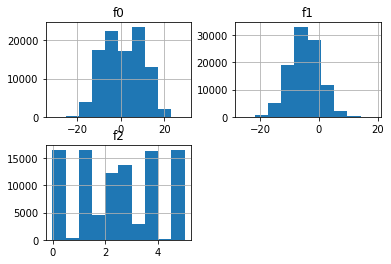

In [7]:
df_analyse(df2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746
5,LzZXx,-0.758092,0.710691,2.585887,90.222465
6,WBHRv,-0.574891,0.317727,1.773745,45.641478
7,XO8fn,-1.906649,-2.458350,-0.177097,72.480640
8,ybmQ5,1.776292,-0.279356,3.004156,106.616832
9,OilcN,-1.214452,-0.439314,5.922514,52.954532


размер:    (100000, 5)
пропусков:          0
дубликатов:    0


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838



Распределение признаков:


<Figure size 1440x720 with 0 Axes>

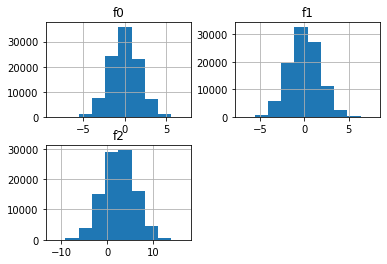

In [8]:
df_analyse(df3)

Во всех датасетах нет пропусков и дубликатов

In [9]:
# удалим столбец id из всех наборов
i = 1
for region in [df1, df2, df3]:
    print(f'Регион {i}: ')
    region=region.drop(['id'],axis=1)
    display(region.head(5))
    print('-----------------------\n\n')
    i+=1

Регион 1: 


,f0,f1,f2,product
0,0.705745,-0.497823,1.221170,105.280062
1,1.334711,-0.340164,4.365080,73.037750
2,1.022732,0.151990,1.419926,85.265647
3,-0.032172,0.139033,2.978566,168.620776
4,1.988431,0.155413,4.751769,154.036647


-----------------------


Регион 2: 


,f0,f1,f2,product
0,-15.001348,-8.276000,-0.005876,3.179103
1,14.272088,-3.475083,0.999183,26.953261
2,6.263187,-5.948386,5.001160,134.766305
3,-13.081196,-11.506057,4.999415,137.945408
4,12.702195,-8.147433,5.004363,134.766305


-----------------------


Регион 3: 


,f0,f1,f2,product
0,-1.146987,0.963328,-0.828965,27.758673
1,0.262778,0.269839,-2.530187,56.069697
2,0.194587,0.289035,-5.586433,62.871910
3,2.236060,-0.553760,0.930038,114.572842
4,-0.515993,1.716266,5.899011,149.600746


-----------------------




## Обучение и проверка модели

In [10]:
def split(data):
    features = data.drop(['product', 'id'], axis=1)
    target = data['product']
    features_train, features_valid, target_train, target_valid = train_test_split(features, 
                                                                                  target, 
                                                                                  test_size=0.25, 
                                                                                  random_state=STATE)
    scaler = MinMaxScaler()
    features_train = scaler.fit_transform(features_train)
    features_valid = scaler.transform(features_valid)
    
    return features_train, features_valid, target_train, target_valid

In [11]:
def train(data):
    features_train, features_valid, target_train, target_valid = split(data)
    lr = LinearRegression(normalize=False)
    lr.fit(features_train, target_train)
    predictions = lr.predict(features_valid)
    predictions = pd.Series(predictions)
    rmse = mean_squared_error(predictions, target_valid,squared=False)
    average_product = sum(predictions) / len(predictions)
    
    print('RMSE: {0:.2f}'.format(rmse))
    print('Average product: {0:.2f}'.format(average_product))
    
    return (predictions, target_valid.reset_index(drop=True), rmse)

In [12]:
i = 1
for region in [df1, df2, df3]:
    print(f'Регион {i}: ')
    train(region)
    print('-----------------------\n\n')
    i+=1

Регион 1: 
RMSE: 37.58
Average product: 92.59
-----------------------


Регион 2: 
RMSE: 0.89
Average product: 68.77
-----------------------


Регион 3: 
RMSE: 39.96
Average product: 95.09
-----------------------




In [13]:
predict_1, valid_1, rmse_1 = train(df1)
predict_2, valid_2, rmse_2 = train(df2)
predict_3, valid_3, rmse_3 = train(df3)

RMSE: 37.58
Average product: 92.66
RMSE: 0.89
Average product: 69.22
RMSE: 40.03
Average product: 95.05


Из вывода видно, что в регионе 1 и 3 предсказанные значение в районе 92 и 95 баррелей но возможность ошибки 37 и 40, А вот уже по региону №2 выходу предсказание продукции получатеся 69 баррелей, квадратичная ошибка предсказания тут уже меньше 1.

## Подготовка к расчёту прибыли

In [14]:
RES_POINTS = 500
TOP_RES_POINTS = 200
BARREL_PRICE = 450
PRODUCT_PRICE = BARREL_PRICE * 1000
REG_BUDGET = 10**10
MAX_LOSS = 0.025

In [15]:
budget_per_point = REG_BUDGET / TOP_RES_POINTS
budget_per_point

50000000.0

Средняя прибыль на лучшие точки 50 млн. руб

In [16]:
min_product = budget_per_point / PRODUCT_PRICE
min_product

111.11111111111111

Мимнимальное кол-во баррелей для безубыточности на точку 111
Запас сырья в скважинах меньше, чем точка безубыточности.

## Расчёт прибыли и рисков 

In [17]:
def profit(predictions, target):
    top_preds = predictions.sort_values(ascending=False)
    top_target = target[top_preds.index][:TOP_RES_POINTS]
    revenue = top_target.sum() * PRODUCT_PRICE
    return revenue - REG_BUDGET

In [18]:
def find_conf_interval_and_loss_risk(predictions, target):
    revenue = []
    for count in range(1000):
        target_sample = target.sample(RES_POINTS, replace=True, random_state=STATE)
        predictions_sample = predictions[target_sample.index]
        revenue.append(profit(predictions_sample, target_sample)) 
        
    lower = int(np.percentile(revenue, 2.5))
    higher = int(np.percentile(revenue, 97.5))
    mean_revenue = int(sum(revenue) / len(revenue))
    risk = st.percentileofscore(revenue, 0)

    return ((lower, higher), mean_revenue, risk)

In [19]:
i = 1
for preds, target in zip([predict_1, predict_2, predict_3], 
                         [valid_1, valid_2, valid_3]):
    interval, mean_revenue, risk = find_conf_interval_and_loss_risk(preds, target)
    print(f'Регион {i}:')
    print("\n-----------------------------------------")
    print(f'средня прибыль: {mean_revenue}')
    print(f'95% Доверительный интервал: {interval}')
    print(f'Риск потери: {risk}')
    print('-----------------------------------------\n\n')
    i+=1

Регион 1:

-----------------------------------------
средня прибыль: 429391603
95% Доверительный интервал: (-84479358, 937137724)
Риск потери: 5.300000000000001
-----------------------------------------


Регион 2:

-----------------------------------------
средня прибыль: 545654352
95% Доверительный интервал: (163077982, 976343911)
Риск потери: 0.2
-----------------------------------------


Регион 3:

-----------------------------------------
средня прибыль: 432511156
95% Доверительный интервал: (-153555072, 967178973)
Риск потери: 6.4
-----------------------------------------





Вывод:

1. В начале мы провели исследовательский анализ данных, проверили датасеты на наличие пропусков, дупликатов, а также посмотрели на распределения признаков, которые, в общем, оказались распределены не нормально.
2. Построили линейную модель, для предсказания объемов нефти в скважинах.
3. Затем мы выполнили процедуру бутстрэпа и нашли 95% доверительный интервал для среднего объема нефти в скважинах. Наиболее перспективным для разработки представляется регион № 2, поскольку риски убытков наименьшие, а средняя прибыль наибольшая.
